In [5]:
airline_file = "data_files/time_series_analysis/airline_passengers.csv"

Machine Learning Model *$y = k*x + b$*

In [6]:
import random
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


class LinearModel:
    """行业写模型已经有了规范，不符合规范的模型，工程师们就不会花时间研究你的模型怎么用
    大家写模型的时候，都用一样的函数，方法。就减少了工程师同样的东西学习很多遍的成本。代码也变得好维护，清晰。
    """

    def __init__(self, initialize_using = 'uniform'):
        """模型超参数"""
        if initialize_using == 'uniform':
            self.init_func = stats.norm.rvs
        else:
            self.init_func = stats.uniform.rvs


    def build(self):
        """随机初始化了模型的参数"""
        self.k = self.init_func()
        self.b = self.init_func()

    def __call__(self, X:np.ndarray):
        """向前传播"""
        return self.k * X + self.b

    def fit(self, X:np.ndarray, y:np.ndarray):
        """参数估计/梯度下降, 一般来说fit过后会返回模型本身"""
        self.build()
        self.k = np.linalg.inv(X.T @ X) @ X.T @ y
        self.b = np.mean(y - self.k * X)
        return self

    def predict(self, X:np.ndarray):
        """预测"""
        return self(X)

    def fit_predict(self, X, y):
        """一次训练和预测"""
        return self.fit(X,y).predict(X)
        

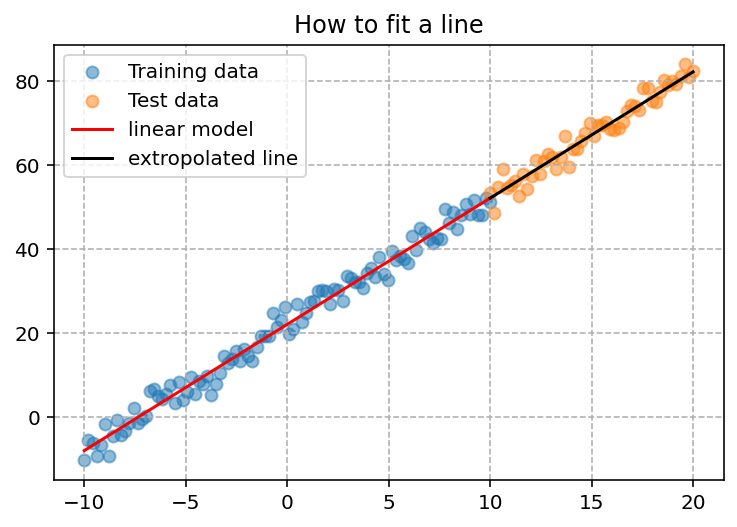

In [7]:
# 准备数据
X_train = np.linspace(-10,10,100).reshape(-1,1)
Y_train = (X_train * 3 +22) + np.random.normal(0,2,X_train.shape)
X_test = np.linspace(10,20,50).reshape(-1,1)
Y_test = (X_test * 3 +22) + np.random.normal(0,2,X_test.shape)

# 准备模型
model = LinearModel()

# 训练模型
model.fit(X_train,Y_train)

# 产生预测
Y1 = model.predict(X_test)

plt.scatter(X_train,Y_train, alpha = 0.5, label = 'Training data')
plt.scatter(X_test,Y_test, alpha = 0.5, label = 'Test data')
plt.plot(X_train,model(X_train), color = 'r', label = 'linear model')
plt.plot(X_test, model(X_test), color = 'k', label = 'extropolated line')
plt.legend(loc = 'upper left')
plt.grid(linestyle = '--')
plt.title("How to fit a line")
plt.show()


初始化以后返回模型本身

In [8]:
from sklearn.linear_model import LinearRegression

LinearRegression()

LinearRegression()

fit过后也返回模型本身，责任链模式

In [9]:
LinearRegression().fit(X_train,Y_train)

LinearRegression()

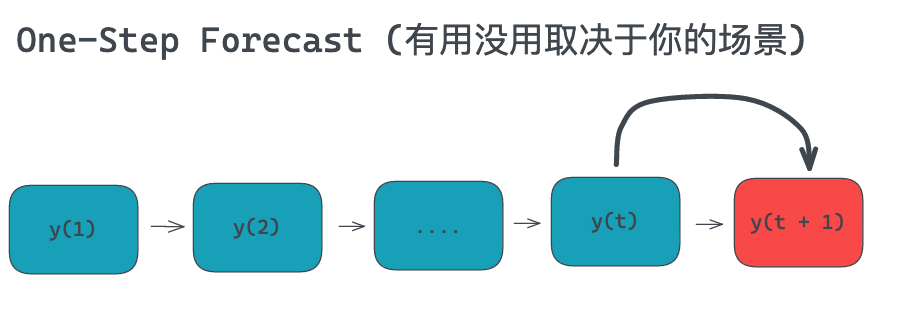

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fintools import (
    create_lag, 
    log_transform, 
    train_test_split)
from functions import compose
%config InlineBackend.figure_format = 'retina'

In [11]:
df = pd.read_csv(airline_file, index_col = 'Month', parse_dates = True)

In [12]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [37]:
preprocess = compose(
    log_transform("Passengers"), 
    create_lag(10, column = 'log_Passengers')
)

preprocess(df).head()

,Passengers,log_Passengers,log_Passengers_lag_1,log_Passengers_lag_2,log_Passengers_lag_3,log_Passengers_lag_4,log_Passengers_lag_5,log_Passengers_lag_6,log_Passengers_lag_7,log_Passengers_lag_8,log_Passengers_lag_9,log_Passengers_lag_10
Month,,,,,,,,,,,,
1949-11-01,104,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,4.770685,4.718499
1949-12-01,118,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,4.770685
1950-01-01,115,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802
1950-02-01,126,4.836282,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812
1950-03-01,141,4.948760,4.836282,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791


### Prepare Dataset

In [101]:
features = ['log_Passengers_lag_1', 'log_Passengers_lag_2', 'log_Passengers_lag_3', 
'log_Passengers_lag_4', 'log_Passengers_lag_5', 'log_Passengers_lag_6', 
'log_Passengers_lag_7', 'log_Passengers_lag_8', 'log_Passengers_lag_9', 
'log_Passengers_lag_10']

target = 'log_Passengers'


X_train, X_test, y_train, y_test = compose(
    log_transform("Passengers"), 
    create_lag(10, column = 'log_Passengers'),
    train_test_split(0.2,features =  features, target = target)
    
)(df)

In [102]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((107, 10), (27, 10), (107,), (27,))

### Machine Learning Approach - In sample Data

In [103]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [104]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((107, 10), (107,), (27, 10), (27,))

In [105]:
X_train

,log_Passengers_lag_1,log_Passengers_lag_2,log_Passengers_lag_3,log_Passengers_lag_4,log_Passengers_lag_5,log_Passengers_lag_6,log_Passengers_lag_7,log_Passengers_lag_8,log_Passengers_lag_9,log_Passengers_lag_10
Month,,,,,,,,,,
1949-11-01,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,4.770685,4.718499
1949-12-01,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802,4.770685
1950-01-01,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812,4.882802
1950-02-01,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791,4.859812
1950-03-01,4.836282,4.744932,4.770685,4.644391,4.779123,4.912655,4.997212,4.997212,4.905275,4.795791
...,...,...,...,...,...,...,...,...,...,...
1958-05-01,5.852202,5.891644,5.762051,5.828946,5.817111,5.720312,5.849325,6.001415,6.146329,6.142037
1958-06-01,5.894403,5.852202,5.891644,5.762051,5.828946,5.817111,5.720312,5.849325,6.001415,6.146329
1958-07-01,6.075346,5.894403,5.852202,5.891644,5.762051,5.828946,5.817111,5.720312,5.849325,6.001415


In [18]:
def evaluate_model(model):
    model.fit(X_train, y_train)

    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    mape_train = mean_absolute_percentage_error(y_train, model.predict(X_train))
    mape_test = mean_absolute_percentage_error(y_test, model.predict(X_test))
    
    return {
        'train_score': train_r2,
        'test_score': test_r2,
        'mape_train': mape_train,
        'mape_test': mape_test
    }

def plot_in_sample_prediction(model, name = ""):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    fig, ax = plt.subplots(figsize = (25,5))
    plt.plot(y_train, label = 'y_train', linestyle = '--')
    plt.plot(y_test, label = 'y_train', linestyle = '--')
    plt.plot(y_train.index, train_pred, label = 'pred')
    plt.plot(y_test.index,test_pred, label = 'pred')
    plt.legend(loc = 'upper left')
    plt.grid(linestyle = '--')
    plt.title(f"OneStep prediction {name}")
    plt.show()

def extropolate(model, X_train, steps = 10):
    prediction = []

    # get the last prediction from train set
    last_value = model.predict(X_train[-1:])
    prediction.append(last_value[0])

    last_feature = X_train[-1:].values.ravel()
    for i in range(steps - 1):

        # concat last predicted value to last feature
        new_feature = np.concatenate(
            [last_value, last_feature], axis = 0)[:-1].reshape(1, -1)

        # make predictions
        pred = model.predict(pd.DataFrame(new_feature, columns = features))

        # update last value and last_feature
        last_value = pred
        last_feature = new_feature.ravel()

        # append prediction to the list
        prediction.append(pred[0])
    return np.array(prediction)

def plot_outof_sample_prediction(model, name = ""):
    fig, ax = plt.subplots(figsize = (22,5))
    plt.plot(np.arange(-len(y_train), 0), y_train, '-',lw = 2, label = 'train', marker = 'o')
    plt.plot(y_test.values, lw = 2, label = 'test', marker = 'o')
    plt.plot(extropolate(model, X_train, len(y_test)), lw = 2, label = 'prediction', marker = 'o')
    plt.grid(linestyle = '--')
    plt.legend(loc = 'upper left')
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"Multistep prediction {name}")
    plt.show()

In [19]:
lr = LinearRegression()

evaluate_model(lr)

{'train_score': 0.9548636368004746,
 'test_score': 0.788602428571517,
 'mape_train': 0.012324642857144937,
 'mape_test': 0.011816597888564125}

*常规的机器学习的evaluation， 只能验证insample data，并不能验证模型的外推能力*

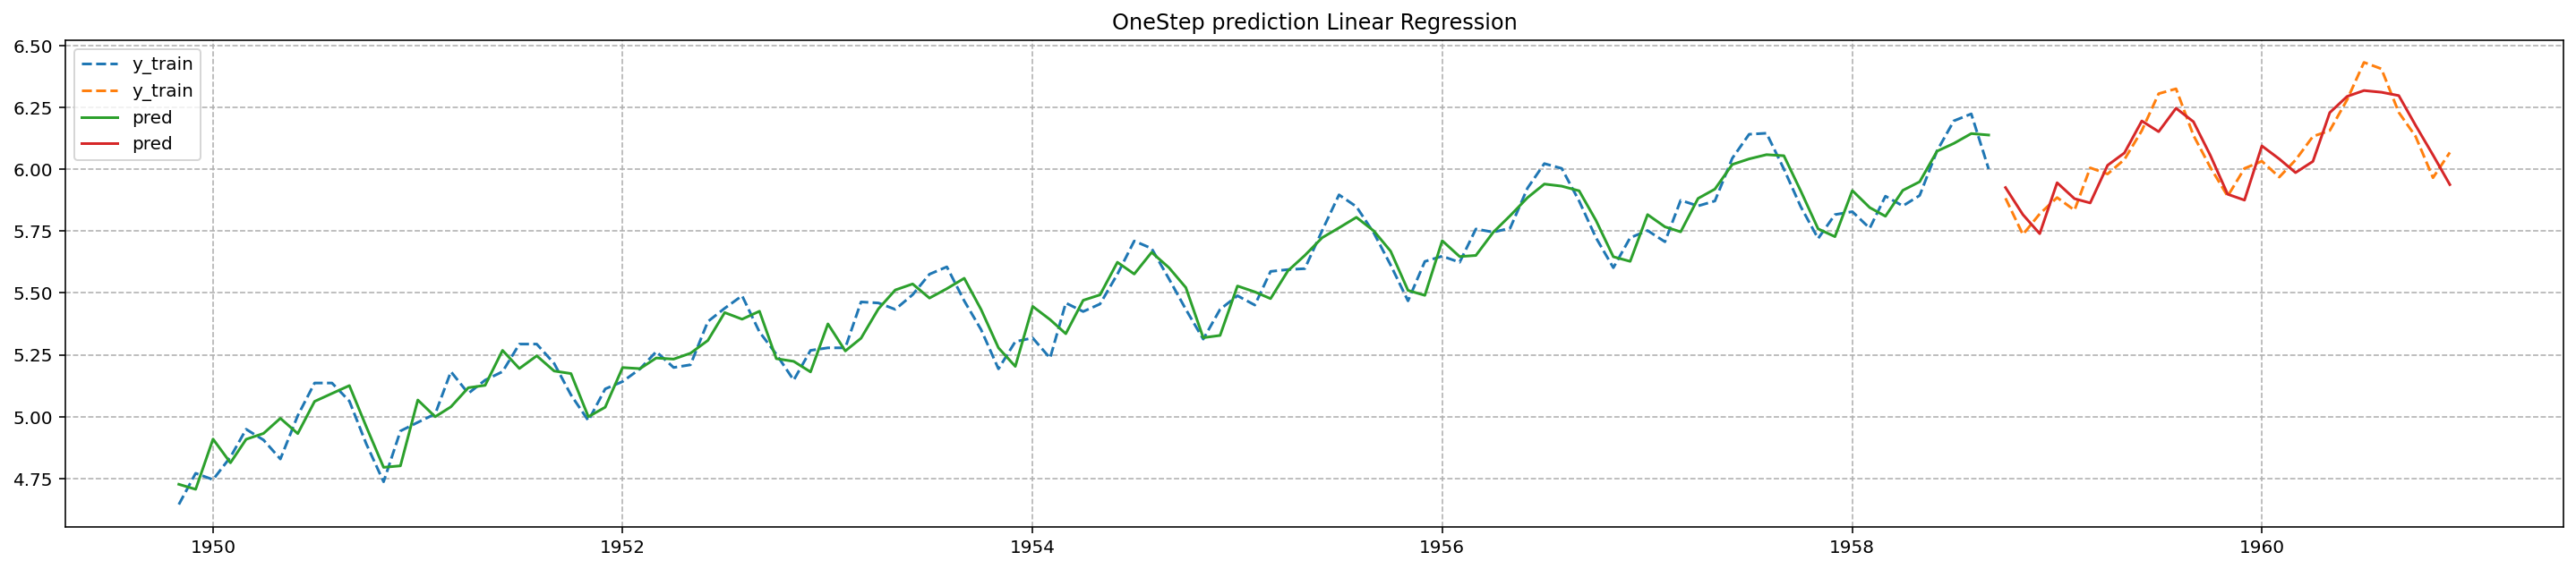

In [20]:
plot_in_sample_prediction(lr,'Linear Regression')

**我们要看的是outof sample data**

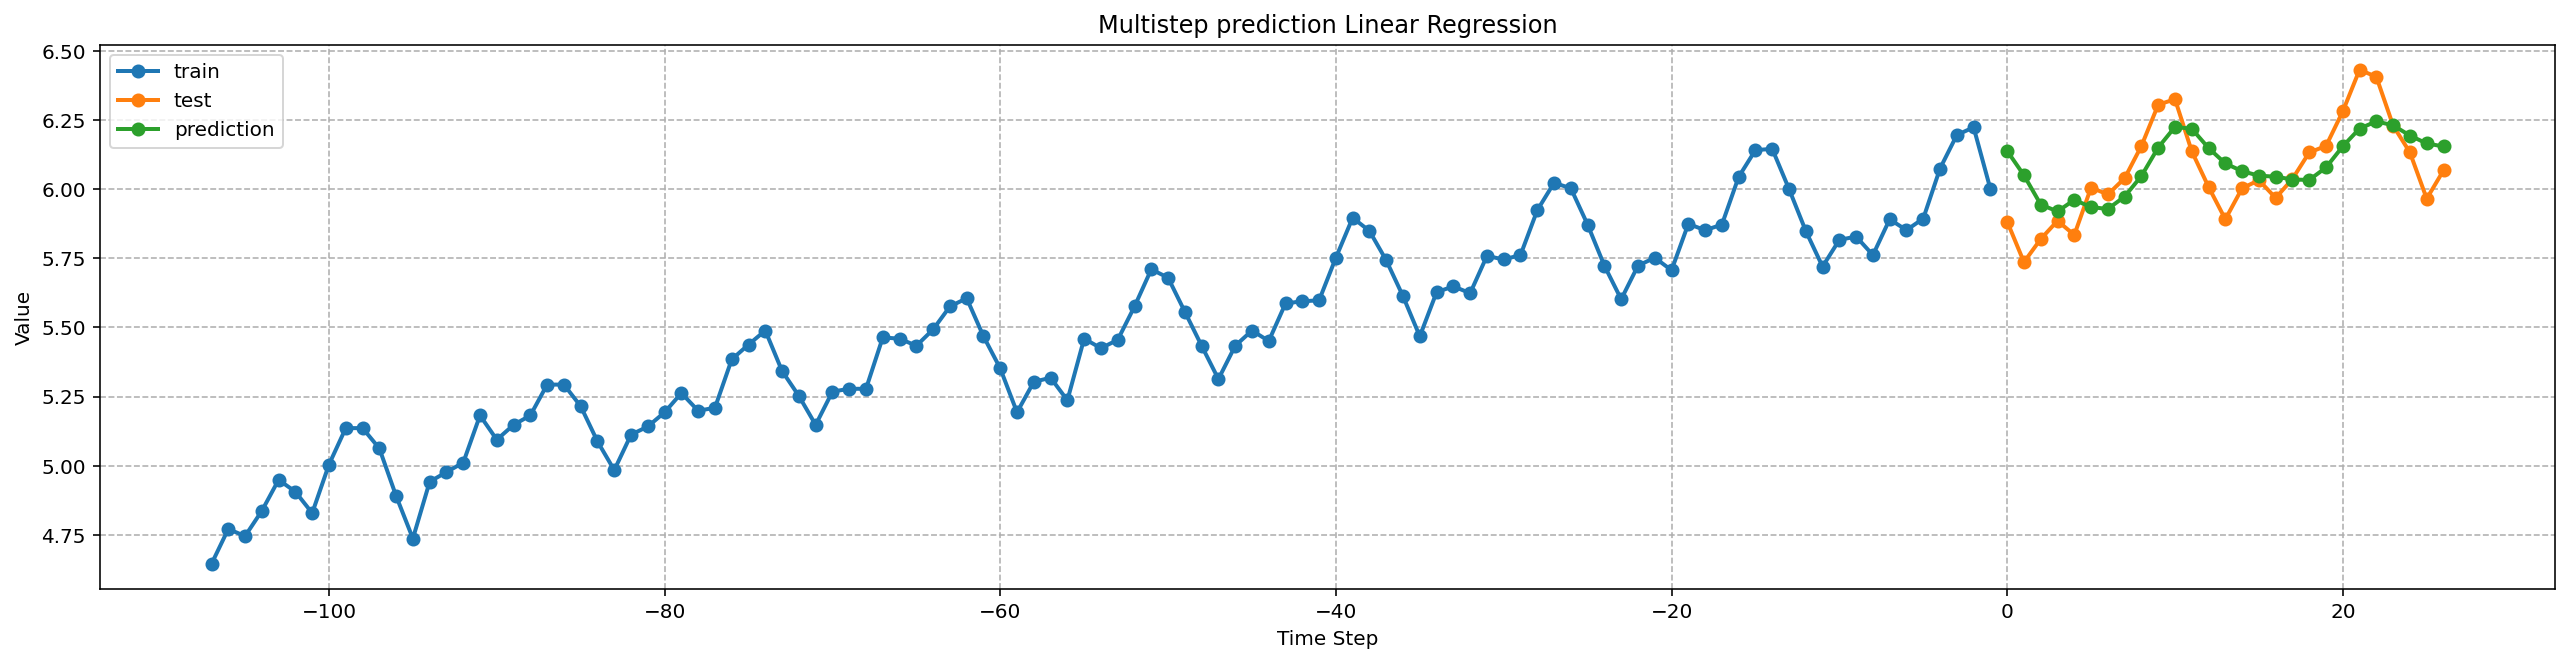

In [21]:
plot_outof_sample_prediction(lr,'Linear Regression')

In [22]:
svr = SVR(kernel = 'rbf', C = 1, gamma = 0.2)

evaluate_model(svr)

{'train_score': 0.9466710099750557,
 'test_score': 0.4896370067002629,
 'mape_train': 0.01364560624309143,
 'mape_test': 0.016502566361773288}

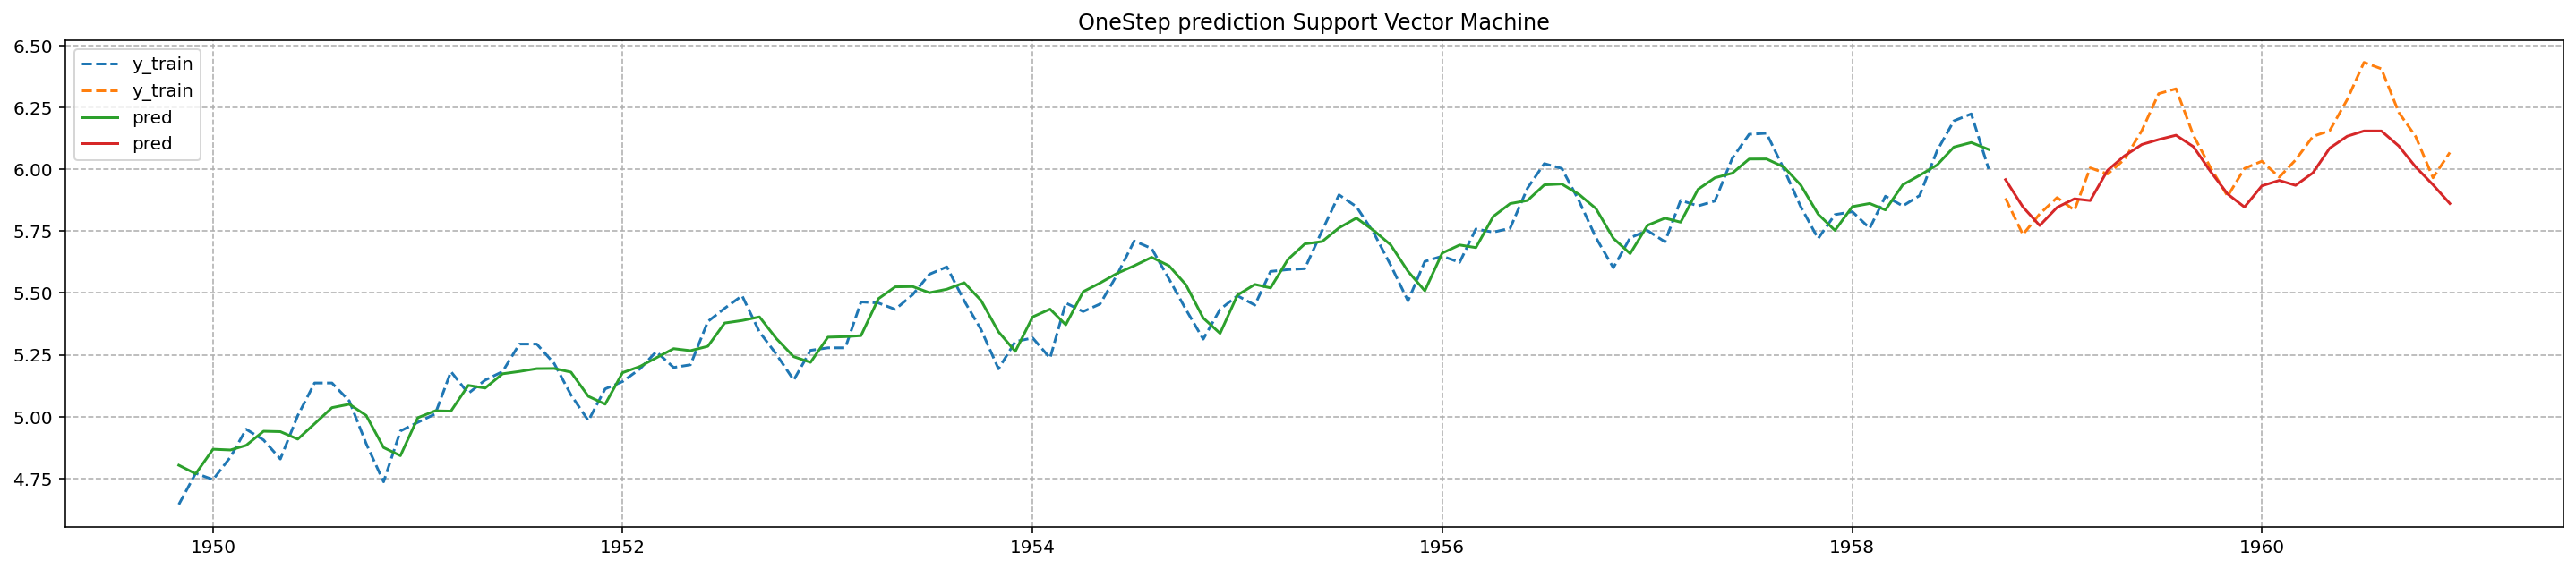

In [23]:
plot_in_sample_prediction(svr, 'Support Vector Machine')

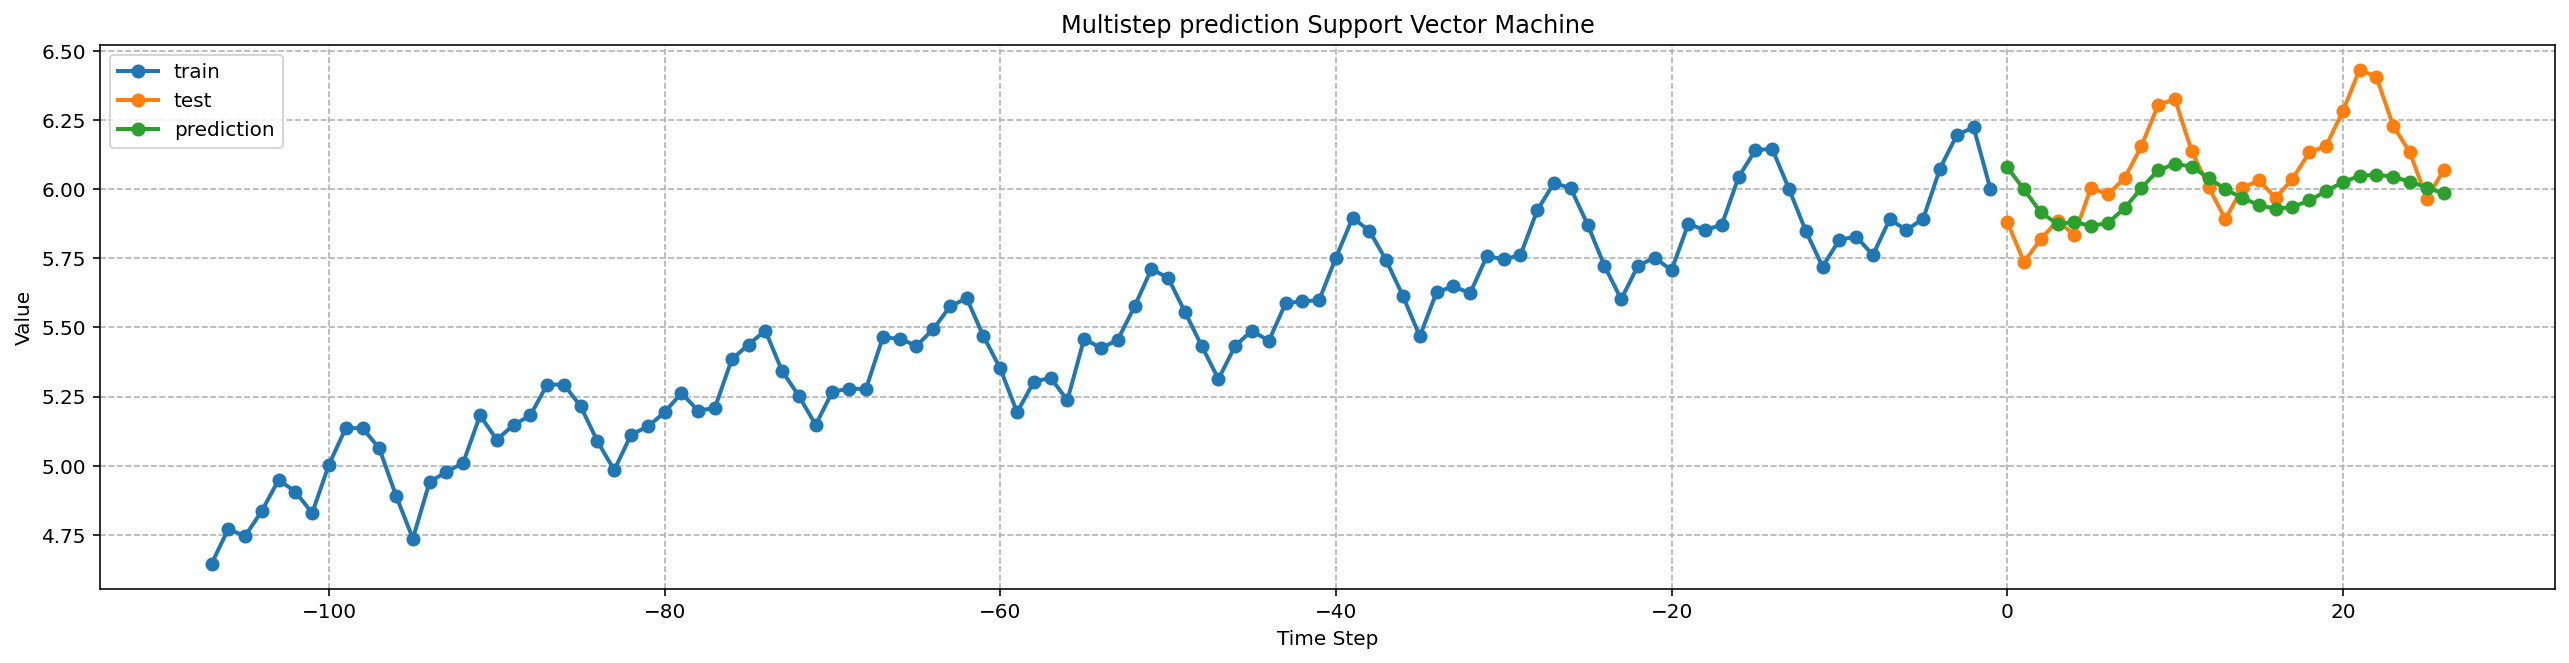

In [24]:
plot_outof_sample_prediction(svr, 'Support Vector Machine')

In [25]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

evaluate_model(rf)

{'train_score': 0.9874517432796063,
 'test_score': 0.4868113426527205,
 'mape_train': 0.006429252262791182,
 'mape_test': 0.01637774698777326}

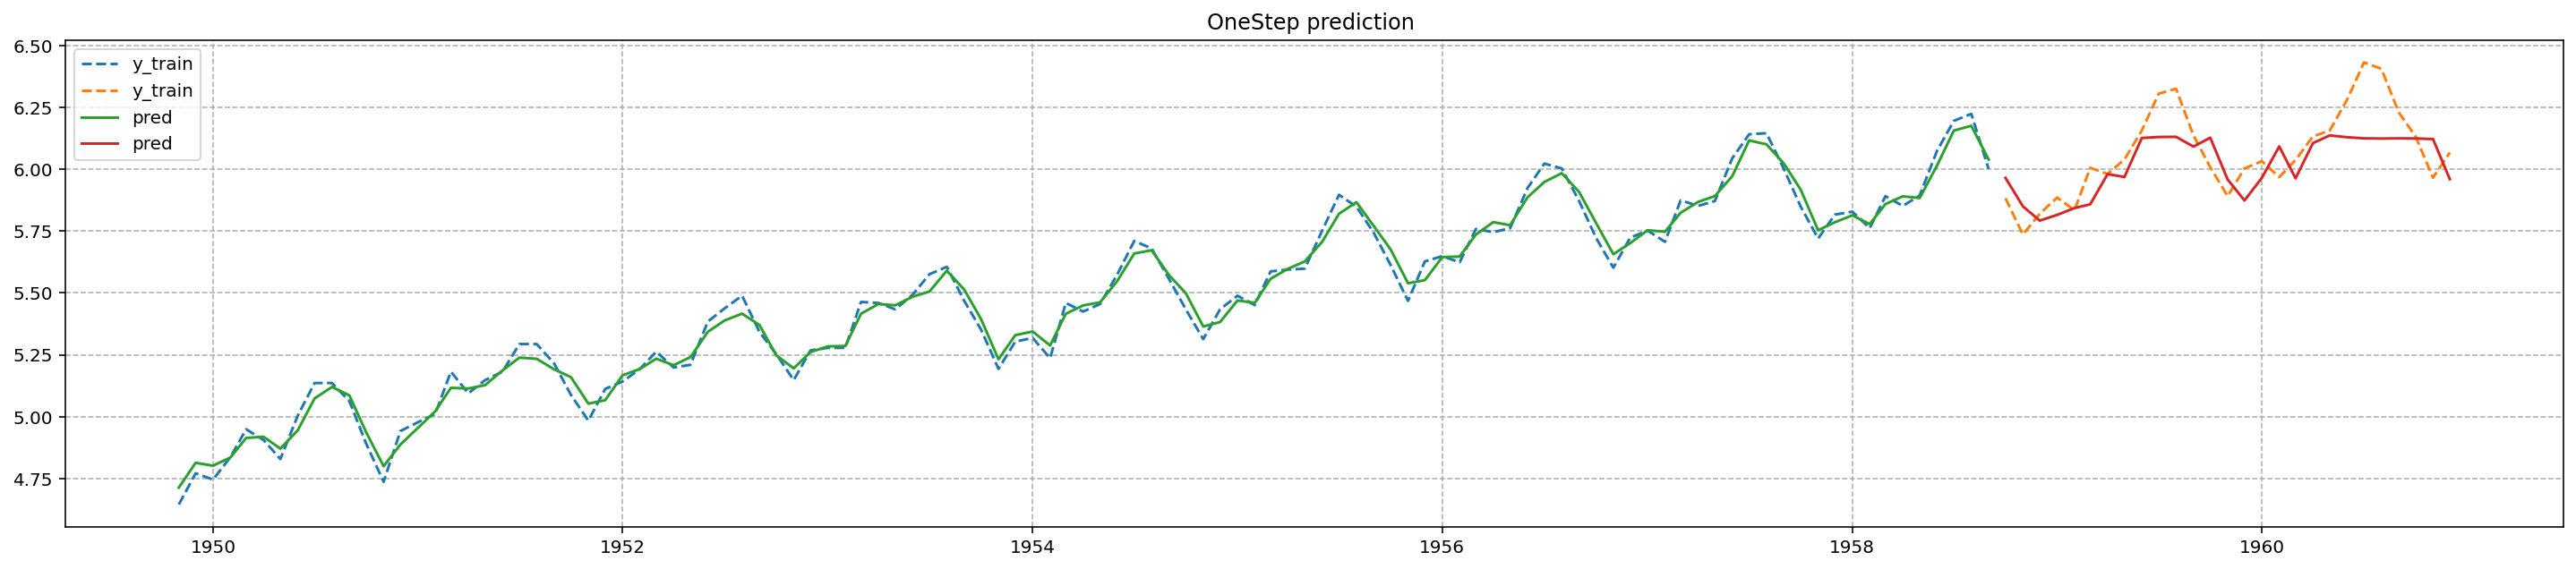

In [26]:
plot_in_sample_prediction(rf)

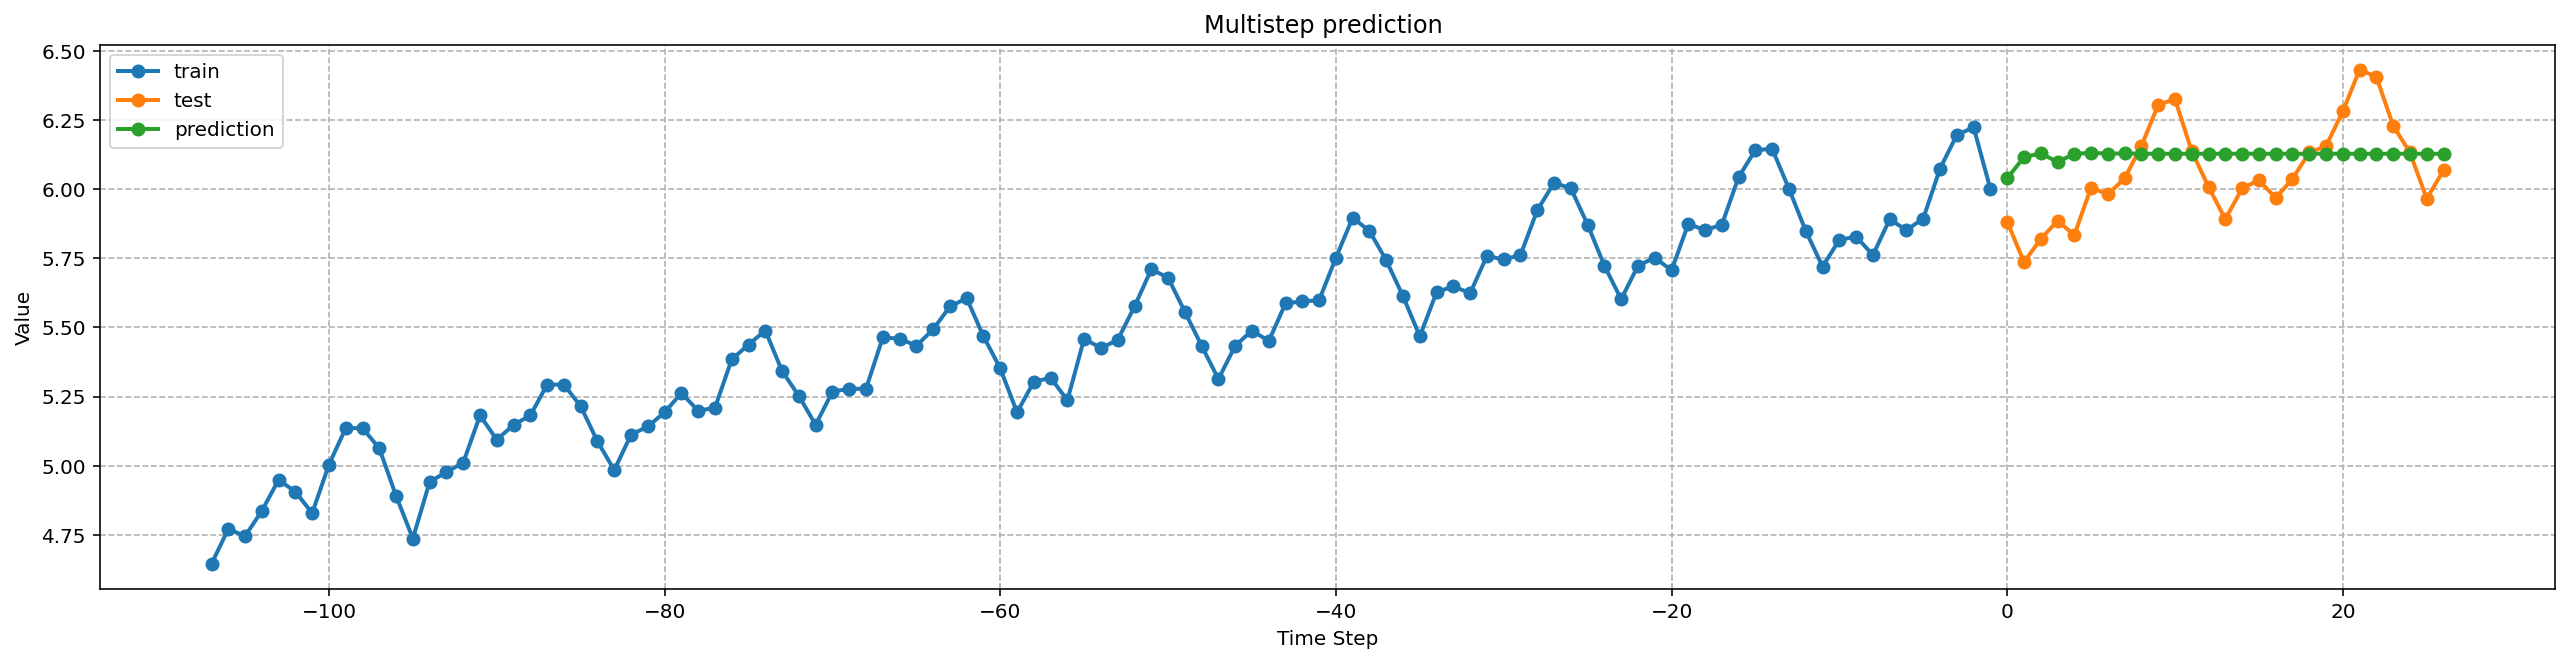

In [27]:
plot_outof_sample_prediction(rf)

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

In [29]:
gb = GradientBoostingRegressor()

In [30]:
evaluate_model(gb)

{'train_score': 0.996916524285507,
 'test_score': 0.32886350097895145,
 'mape_train': 0.0030372826490602275,
 'mape_test': 0.019375569718969463}

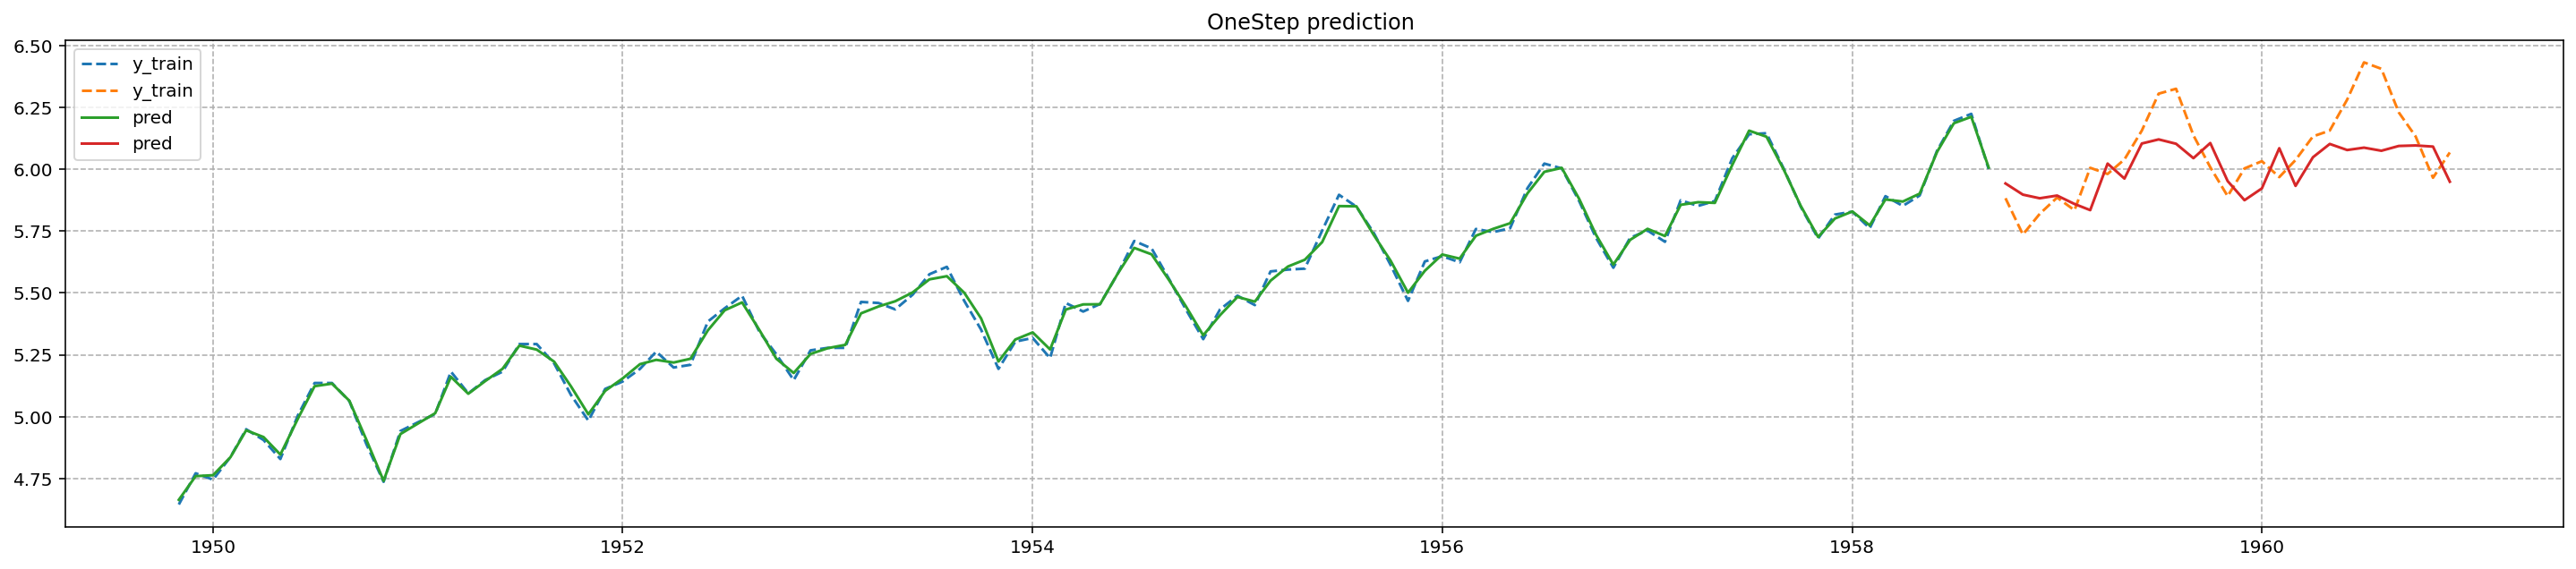

In [31]:
plot_in_sample_prediction(gb)

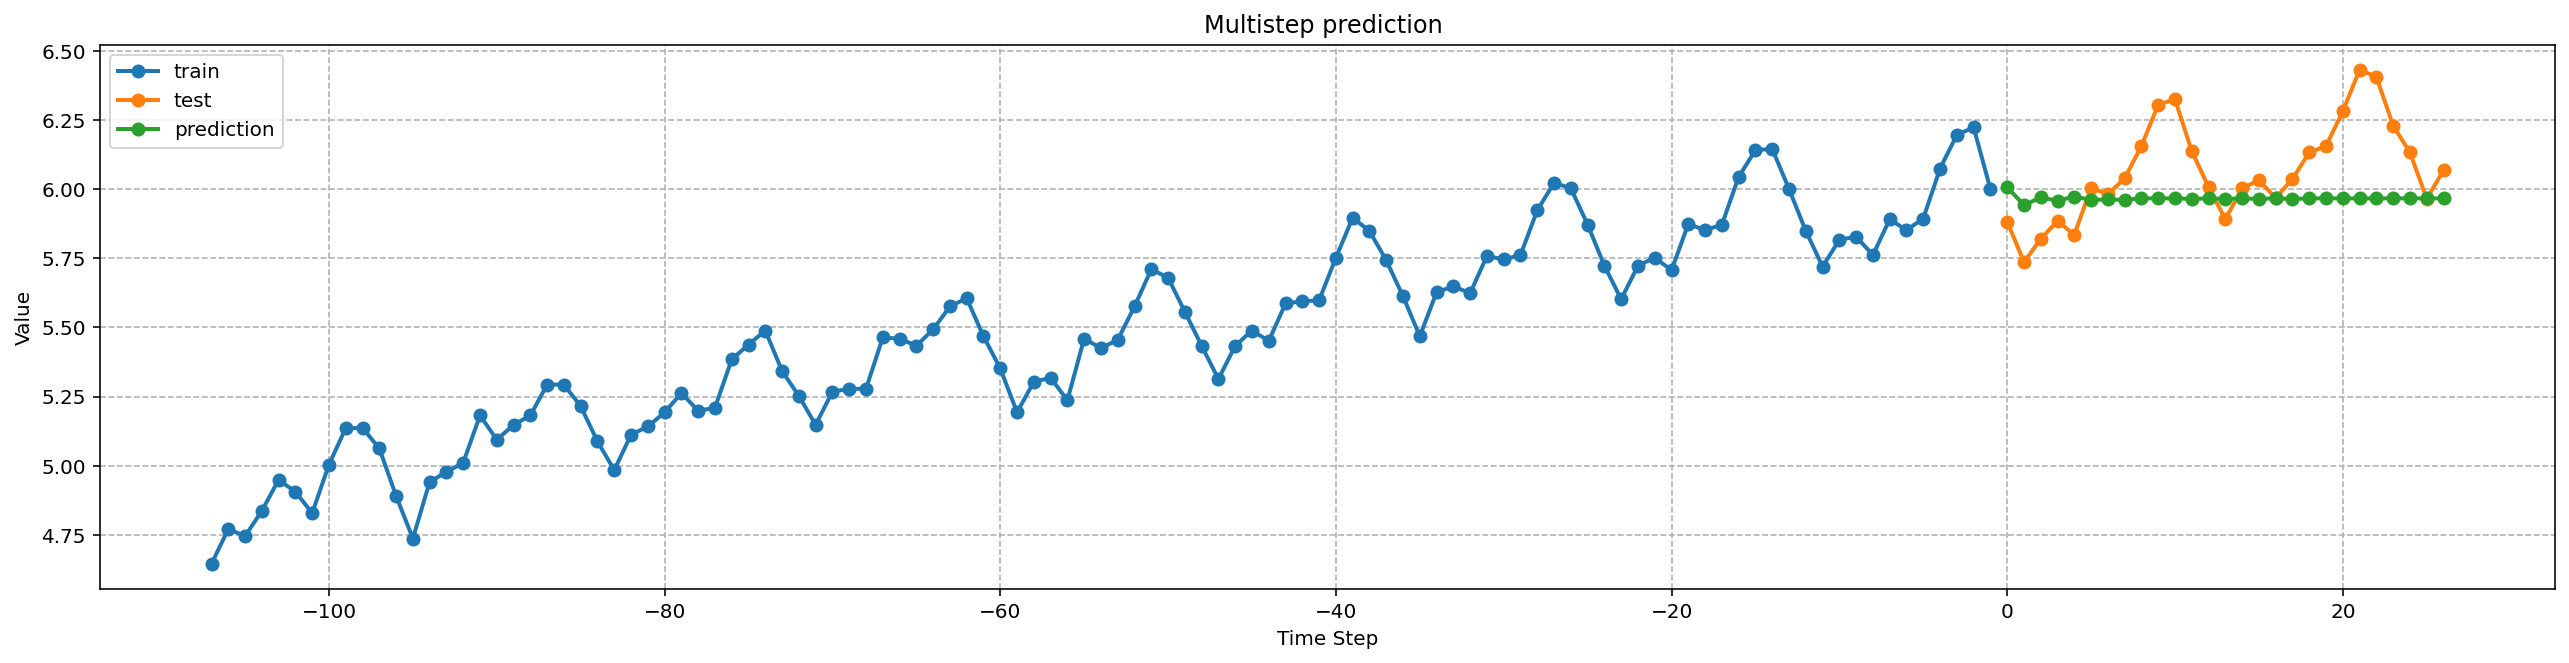

In [32]:
plot_outof_sample_prediction(gb)

### Prophet

In [73]:
from prophet import Prophet

In [112]:
pdf = df.copy()

pdf['ds'] = pdf.index
pdf['y'] = pdf['Passengers']

pdf = pdf[['ds','y']]
pdf['ds'] = pdf.ds.asfreq("MS")

In [126]:
m = Prophet() # seasonality_mode="multiplicative"

m.fit(pdf)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502


/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       401.676    0.00248047       124.072           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       401.794   6.53748e-05       58.9607   1.051e-06       0.001      209  LS failed, Hessian reset 
     199       401.842   7.96656e-05       76.5629           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       401.847   9.58429e-06       62.8741   1.173e-07       0.001      341  LS failed, Hessian reset 
     299       401.875   0.000423503       97.4976           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       401.939   0.000255806       95.7883   2.552e-06       0.001      496  LS failed, Hessian reset 
     399       401.979   1.11763e-05  

In [127]:
future = m.make_future_dataframe(periods = 30,freq = "M")

In [128]:
m.predict(future)

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,107.496988,55.990749,113.902560,107.496988,107.496988,-21.382730,-21.382730,-21.382730,-21.382730,-21.382730,-21.382730,0.0,0.0,0.0,86.114258
1,1949-02-01,109.639972,49.915973,109.429755,109.639972,109.639972,-30.048398,-30.048398,-30.048398,-30.048398,-30.048398,-30.048398,0.0,0.0,0.0,79.591574
2,1949-03-01,111.575570,82.940095,139.351776,111.575570,111.575570,-0.470987,-0.470987,-0.470987,-0.470987,-0.470987,-0.470987,0.0,0.0,0.0,111.104583
3,1949-04-01,113.718554,82.292759,135.578145,113.718554,113.718554,-4.925482,-4.925482,-4.925482,-4.925482,-4.925482,-4.925482,0.0,0.0,0.0,108.793071
4,1949-05-01,115.792409,83.057694,139.792117,115.792409,115.792409,-3.622094,-3.622094,-3.622094,-3.622094,-3.622094,-3.622094,0.0,0.0,0.0,112.170314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,1963-01-31,564.695770,493.841747,554.521195,562.663796,566.748681,-39.184888,-39.184888,-39.184888,-39.184888,-39.184888,-39.184888,0.0,0.0,0.0,525.510882
170,1963-02-28,567.523901,547.434137,605.197729,565.380387,569.685774,9.314041,9.314041,9.314041,9.314041,9.314041,9.314041,0.0,0.0,0.0,576.837942
171,1963-03-31,570.655045,530.394076,587.234185,568.368985,572.952384,-10.693597,-10.693597,-10.693597,-10.693597,-10.693597,-10.693597,0.0,0.0,0.0,559.961448
172,1963-04-30,573.685185,546.169781,601.616412,571.216401,576.149412,1.324692,1.324692,1.324692,1.324692,1.324692,1.324692,0.0,0.0,0.0,575.009877


In [ ]:
"YYYY-MM-DD"
"YYYY-MM-DD HH:MM:SS"

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


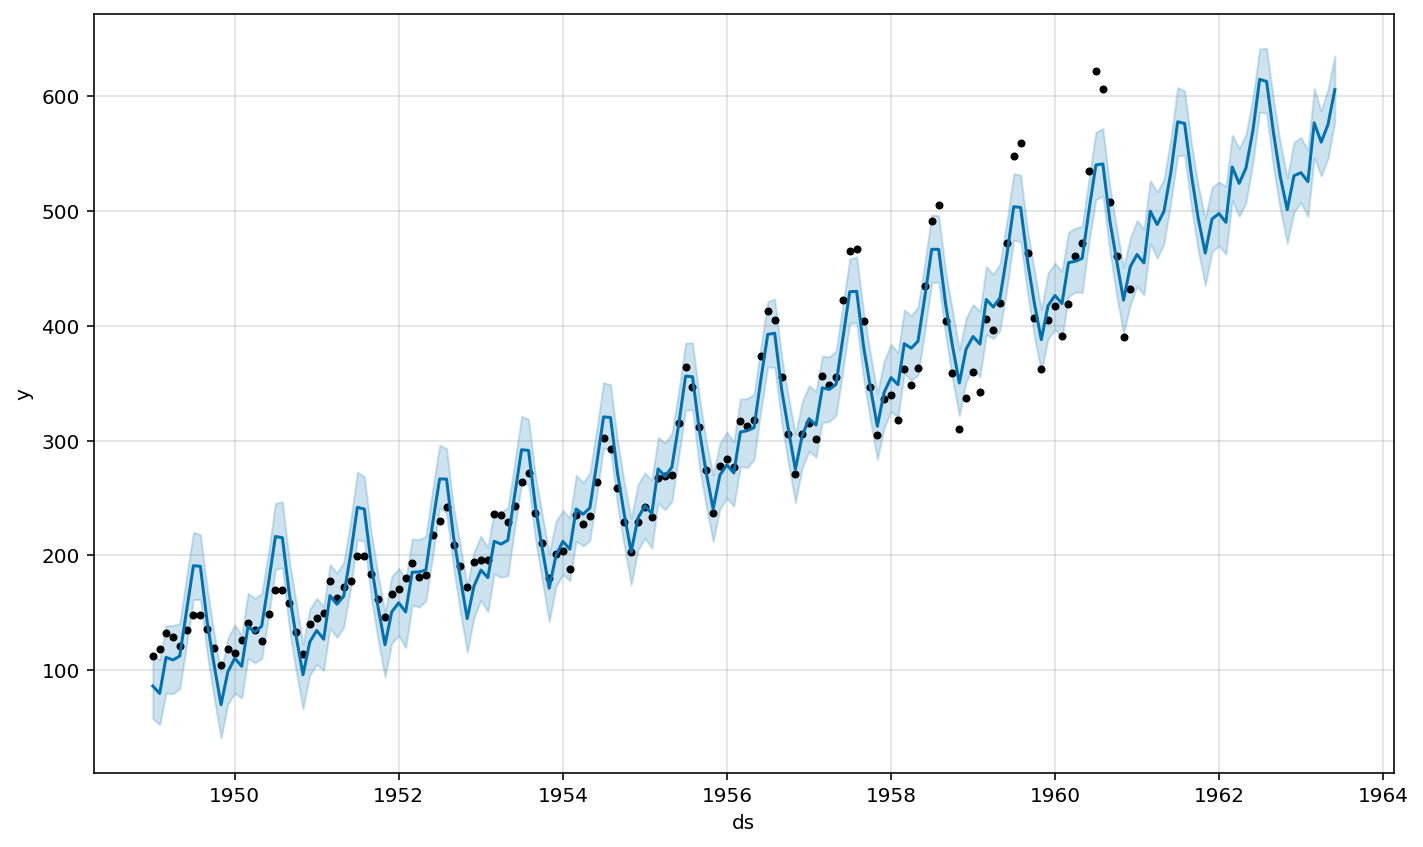

In [129]:
_ = m.plot(m.predict(future))